## Collaborative Filtering using Item Response Theory

- Div Vats
- Data Scientist @ Sailthru

- Example: Students answering questions

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | | | | | | | | 
| user_2  | | | | | | | | 
| user_3  | | | | | | | | 
| user_4  | | | | | | | | 
| user_5  | | | | | | | | 
| user_6  | | | | | | | | 
| user_7  | | | | | | | | 
| user_8  | | | | | | | | 
| user_9  | | | | | | | | 
| user_10 | | | | | | | |


- Example: Students answering questions

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| | 0| 0| 1| | 
| user_2  | 1| | 1| | 0| | 1| 
| user_3  | | | 0| | 1| | 1| 
| user_4  | 1| | 0| | 0| | 1| 
| user_5  | 0| | 1| | 1| | | 
| user_6  | | 1| 1| | 0| | | 
| user_7  | 0| 0| | 0| | 1| | 
| user_8  | 1| 0| 1| | | 0| | 
| user_9  | 1| 1| | 0| | | 0| 
| user_10 | 0| 0| | | | 1| 1|


- Example: Can we estimate the missing answers?

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| ?| 0| 0| 1| ?| 
| user_2  | 1| ?| 1| ?| 0| ?| 1| 
| user_3  | ?| ?| 0| ?| 1| ?| 1| 
| user_4  | 1| ?| 0| ?| 0| ?| 1| 
| user_5  | 0| ?| 1| ?| 1| ?| ?| 
| user_6  | ?| 1| 1| ?| 0| ?| ?| 
| user_7  | 0| 0| ?| 0| ?| 1| ?| 
| user_8  | 1| 0| 1| ?| ?| 0| ?| 
| user_9  | 1| 1| ?| 0| ?| ?| 0| 
| user_10 | 0| 0| ?| ?| ?| 1| 1|


- One Approach: Aggregrate statistics for each question
    - For Q1: 4/8 correct => 0.5 probability of a user answering Q1 correctly

|| Q1 |
|-|
| user_1  | 0| 
| user_2  | 1| 
| user_3  | ?| 
| user_4  | 1| 
| user_5  | 0| 
| user_6  | ?| 
| user_7  | 0| 
| user_8  | 1| 
| user_9  | 1| 
| user_10 | 0|


- Another Approach: Aggregrate statistics for each user
    - For user_1: 2/5 correct => 0.4 probability of user_1 answering a question correctly

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| ?| 0| 0| 1| ?|

- Pros
    - Extremely simple!
- Cons
    - Limited modeling capability
    - Question based: The ability (smartness) of users may vary
    - User based: The difficulty of questions may vary

## Same problems in other domains

<img src="http://gerardnico.com/wiki/_media/data_mining/rating_collaborative_filtering.png?w=200&tok=68baf2" width=250 height=250/>

## Item Response Theory

- Simple framework for jointly using item and user based popularity
- Subset of more general matrix factorization algorithms
- Key idea:
    $$\displaystyle{P(Y_{i,j} = 1) = \frac{1}{1 + \exp(-(a_i + b_j))}}$$
    - $Y_{i,j}$: correct/incorrect response from user $i$ to item $j$
    - $a_i$: ability of user $i$ (how smart is user $i$)
    - $b_j$: difficulty of item $j$

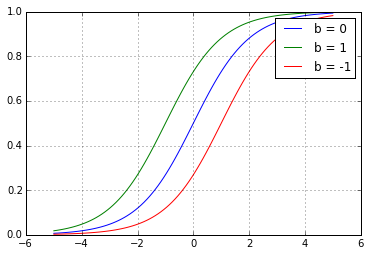

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def logit(c):
    return 1 / (1 + np.exp(-c))

a = np.linspace(-5,5,100)
plt.plot(a, logit(a + 0))
plt.plot(a, logit(a + 1))
plt.plot(a, logit(a - 1))
plt.grid()
plt.legend(('b = 0','b = 1','b = -1'))

$$\displaystyle{P(Y_{i,j} = 1) = \frac{1}{1 + \exp(-(a_i + b_j))}}$$

### Question: How can I estimate $a_i$ and $b_j$ given $Y$?

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| | 0| 0| 1| | 
| user_2  | 1| | 1| | 0| | 1| 
| user_3  | | | 0| | 1| | 1| 
| user_4  | 1| | 0| | 0| | 1| 
| user_5  | 0| | 1| | 1| | | 
| user_6  | | 1| 1| | 0| | | 
| user_7  | 0| 0| | 0| | 1| | 
| user_8  | 1| 0| 1| | | 0| | 
| user_9  | 1| 1| | 0| | | 0| 
| user_10 | 0| 0| | | | 1| 1|